# Introduction to Keras

#### OHBM 2018 Education Course 

Anisha Keshavan


University of Washington


**Contact**: email: [anishakeshavan@gmail.com](mailto:anishakeshavan@gmail.com) , Twitter: [@akeshavan\_](https://twitter.com/akeshavan_)

## Set Up:

3 ways to set up:
    
1. If you have a Python environment set up on your computer: 
    
        git clone https://github.com/brainhack101/IntroDL
        cd IntroDL
        pip install -r requirements.txt
        jupyter notebook

2. Go to https://notebooks.azure.notebooks.com

3. Go to colaboratory

## What is Keras?

## Concepts in this Notebook

1. Loading and viewing data

2. Layers: Convolutional, Fully Connected, Max Pooling

3. Optimizers

4. Loss functions

5. Fitting the model and viewing results

## Goal for this Tutorial

Our goal in this tutorial is to predict whether an image has an Anterior-Posterior flip. In large data collection studies, sometimes that coordinate space of images gets flipped, and we want to be able to quickly detect this inconsistency.

We will use Python and Keras to do the following:

1. [Load data](#Loading-Data) from IXI dataset
2. [Visualize](#Viewing-Data) the slices from our dataset
3. [Create AP flipped data](#Introducing-an-AP-Flip) so that we can train our model
4. [Create our labels](#Creating-the-Label): this is what our model will predict
5. [Build a model]()
6. [Fit our model]()

### Loading Data

Our data is stored as a **zip** file in the `sample_data` folder

#### Unzip the data

In [ ]:
!unzip sample_data/IXI_small.zip -d sample_data/

#### Count the number of jpg files we have

The `glob` function in python will return a list of files that match our pattern

In [19]:
from glob import glob

image_files = glob('sample_data/*.jpg')
N = len(image_files)
print(N)

590


#### Load our label file

In [33]:
%matplotlib inline
import nibabel as nib
import numpy as np
import os, csv
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd

In [ ]:
pd.read_csv("./")

#### Load JPG images into a numpy array

In [17]:
def load_image(filename):
    data_slice = plt.imread(filename)
    assert data.shape == (256,256), "image file is not the right shape"
    return data_slice

In [73]:
# initialize an array that is the shape we need:

X = np.zeros((N, 256, 256, 1)) 
# the last dimension is the number of channels in the image.
# a grayscale image has 1 channel, while an RGB image has 3 channels (R,G,B)

# iterate through all of the image files
for i, file in enumerate(image_files):
    # in Python, enumerate is a special function that gives us 
    # an index (i) and the item in the list (file)
    
    
    # load the file using our function
    data_slice = load_image(file)
    
    # put the data into our array, X
    X[i, :, :, 0] = data_slice

### Viewing Data

In [74]:
def view_slice(X_data, index):
    plt.imshow(X_data[index,:,:,0],cmap=plt.cm.Greys_r)
    plt.axis('off');

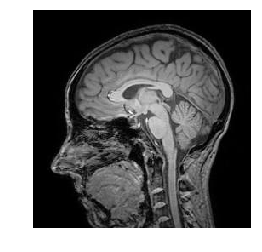

In [75]:
view_slice(X, 0)

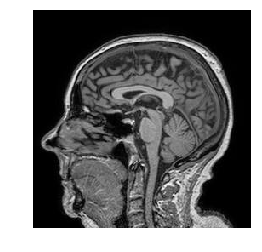

In [76]:
view_slice(X, 200)

### Introducing an AP Flip

In [77]:
X_flip = X[:,:,::-1,:]

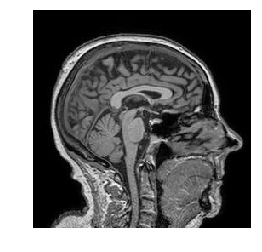

In [78]:
view_slice(X_flip, 200)

#### Combine X and X_flip into 1 array

In [79]:
X = np.vstack((X, X_flip))

In [80]:
X.shape

(1180, 256, 256, 1)

### Creating the Label

We know the first half of the X array corresponds to images that are the right orientation

In [81]:
y_label = np.zeros(X.shape[0])
y_label[:N] = 1

In [82]:
from keras.utils import to_categorical

In [83]:
y = to_categorical(y_label)

In [84]:
y

array([[0., 1.],
       [0., 1.],
       [0., 1.],
       ...,
       [1., 0.],
       [1., 0.],
       [1., 0.]])

Shuffle the data so that the samples aren't grouped

In [86]:
shuffled_indices = np.arange(2*N)
np.random.shuffle(shuffled_indices)
X = X[shuffled_indices, :,:,:]
y = y[shuffled_indices, :]

In [87]:
print(X.shape, y.shape)

(1180, 256, 256, 1) (1180, 2)


In [88]:
y

array([[1., 0.],
       [0., 1.],
       [0., 1.],
       ...,
       [1., 0.],
       [0., 1.],
       [0., 1.]])

## Creating a Sequential Model

import the necessary libs

In [90]:
import tensorflow as tf
tf.device('cpu')
from keras.models import Sequential

from keras.layers import Dense, Flatten, Dropout
from keras.layers import Conv2D, BatchNormalization, MaxPooling2D

from keras.optimizers import Adam

from keras import backend as K
K.clear_session()

In [97]:
kernel_size = (3, 3)
n_classes = 2

filters = 8

model = Sequential()

model.add(Conv2D(filters, kernel_size, activation='relu', input_shape=(256, 256, 1)))

model.add(BatchNormalization())

model.add(MaxPooling2D())
model.add(Conv2D(filters*2, kernel_size, activation='relu'))

model.add(MaxPooling2D())
model.add(Conv2D(filters*4, kernel_size, activation='relu'))

model.add(MaxPooling2D())
model.add(Conv2D(filters*8, kernel_size, activation='relu'))

model.add(MaxPooling2D())
model.add(Flatten())

model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(n_classes, activation='softmax'))

adam = Adam(lr=0.00002)

model.compile(loss='categorical_crossentropy',
                 optimizer=adam,
                 metrics=['accuracy'])

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 254, 254, 8)       80        
_________________________________________________________________
batch_normalization_2 (Batch (None, 254, 254, 8)       32        
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 127, 127, 8)       0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 125, 125, 16)      1168      
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 62, 62, 16)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 60, 60, 32)        4640      
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 30, 30, 32)        0         
__________

In [98]:
fit = model.fit(X, y, epochs=10, batch_size=2)

Epoch 1/10
1180/1180 [==============================] - 5s 4ms/step - loss: 0.3593 - acc: 0.8297
Epoch 2/10
1180/1180 [==============================] - 5s 4ms/step - loss: 0.0948 - acc: 0.9661
Epoch 3/10
1180/1180 [==============================] - 5s 4ms/step - loss: 0.0419 - acc: 0.9831
Epoch 4/10
1180/1180 [==============================] - 5s 4ms/step - loss: 0.0323 - acc: 0.9907
Epoch 5/10
1180/1180 [==============================] - 5s 4ms/step - loss: 0.0186 - acc: 0.9949
Epoch 6/10
1180/1180 [==============================] - 5s 4ms/step - loss: 0.0150 - acc: 0.9958
Epoch 7/10
1180/1180 [==============================] - 5s 4ms/step - loss: 0.0084 - acc: 0.9975
Epoch 8/10
1180/1180 [==============================] - 5s 4ms/step - loss: 0.0178 - acc: 0.9907
Epoch 9/10
1180/1180 [==============================] - 5s 4ms/step - loss: 0.0065 - acc: 0.9966
Epoch 10/10
1180/1180 [==============================] - 5s 4ms/step - loss: 0.0097 - acc: 0.9958


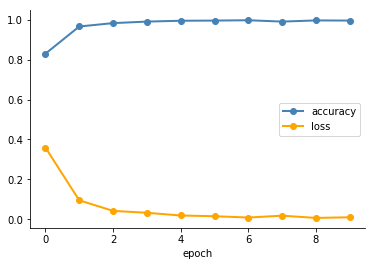

In [108]:
fig, ax = plt.subplots(1)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
epoch = np.arange(10)
ax.plot(epoch, fit.history['acc'], marker="o", linewidth=2, color="steelblue", label="accuracy")
ax.plot(epoch, fit.history['loss'], marker="o", linewidth=2, color="orange", label="loss")
ax.set_xlabel('epoch')
ax.legend();